# Exploration of local defocus shifts as a particle rejection criterion
This exploration was motivated by olibclarke's question at https://discuss.cryosparc.com/t/11632/5.

## Required
- Exposures with estimated `ctf/df1_A` values
- Particles with refined `ctf/df1_A` values
- A file with _valid_ CryoSPARC instance (connection) information like
  ```yaml
  license: 682437fb-d6ae-47b8-870b-b530c587da94
  host: localhost
  base_port: 39000
  email: username@email.server
  password: top7secret-phrase
  ```
  Actual values must correspond to the relevant CryoSPARC instance and CryoSPARC UI login information.
- a python environment with, aside from cryosparc-tools
  - pandas

In [2]:
%matplotlib inline
from cryosparc.tools import CryoSPARC
import cryosparc.dataset
import pandas
import random
import yaml
from IPython.display import Markdown # https://stackoverflow.com/a/47310524

instance_info_file = '/tmp/release.yaml' # as described above

with open(instance_info_file, 'r') as yh:
    cs = CryoSPARC(**yaml.safe_load(yh))

## Input data, etc.

In [22]:
project_uid = 'P44'
workspace_uid = 'W9'
ctf_uid = 'J4'
refine_uid = 'J17'
compute_lane = 'cryoem6'

In [6]:
Markdown(f"""
{ctf_uid} and {refine_uid} are completed _Patch CTF_ and _Home Refine_
jobs from a run of the [benchmark workflow](
https://guide.cryosparc.com/setup-configuration-and-management/software-system-guides/tutorial-verify-cryosparc-installation-with-the-extensive-workflow-sysadmin-guide) based on a subset of [EMPIAR-10025](https://doi.org/10.6019/EMPIAR-10025
) movies.
""")


J4 and J17 are completed _Patch CTF_ and _Home Refine_
jobs from a run of the [benchmark workflow](
https://guide.cryosparc.com/setup-configuration-and-management/software-system-guides/tutorial-verify-cryosparc-installation-with-the-extensive-workflow-sysadmin-guide) based on a subset of [EMPIAR-10025](https://doi.org/10.6019/EMPIAR-10025
) movies.


In [7]:
project = cs.find_project(project_uid)
ctf_output = project.find_job(ctf_uid).load_output('exposures')
refine_output = project.find_job(refine_uid).load_output('particles')

For convienience, loaded datasets are converted to `pandas.DataFrame`s. The exposures dataset's index is [converted to a an `index` column](https://stackoverflow.com/a/20461206) for use in plotting, later. Particle and exposure datasets are joined on the exposure UIDs.

In [8]:
joined = pandas.DataFrame(refine_output.rows()).merge(
            right=pandas.DataFrame(ctf_output.rows()).reset_index(),
            left_on='location/micrograph_uid', right_on='uid',
            suffixes=('.particle', '.exposure'))

## Hypothesis
Removal of particles with (absolute) shifts in their refined defocus values will result in a higher resolution reconstruction. Please refer to https://discuss.cryosparc.com/t/11632/5 for the olibclarke's actual intent.

Initially, we name and define a selection criterion as below. One may experiment with different definitions.

In [9]:
criterion = 'ctf/df1_A_diff'
joined[criterion] = joined['ctf/df1_A.particle'] - joined['ctf/df1_A.exposure']

## Exploration

### Distribution of shifts from exposure defocus over entire dataset

In [10]:
joined[criterion].describe()

count    11736.000000
mean        67.377121
std        158.292664
min       -808.642578
25%        -18.759766
50%         69.953613
75%        166.506836
max        648.212891
Name: ctf/df1_A_diff, dtype: float64

### Distribution of shifts from exposure defocus per micrograph

<Axes: title={'center': 'ctf/df1_A_diff'}, xlabel='index'>

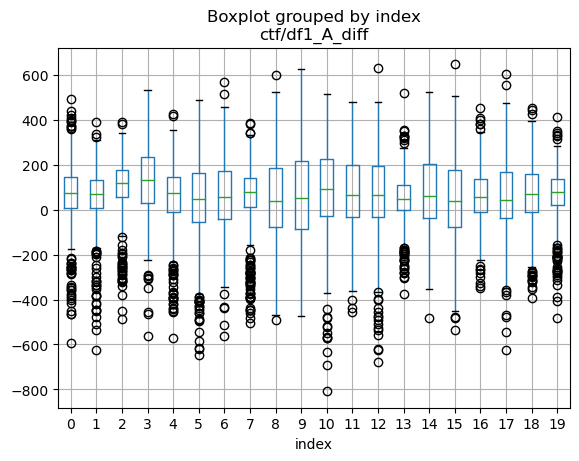

In [11]:
joined.boxplot(column=criterion, by='index')

In [17]:
reject_below = -50
reject_above = 200
criterion_unit = '&Aring;'

Markdown(f"""
We next examine the effect of discarding particles whose `{criterion}`
fall outside the ({reject_below}{criterion_unit}, {reject_above}{criterion_unit})
interval.
""")


We next examine the effect of discarding particles whose `ctf/df1_A_diff`
fall outside the (-50&Aring;, 200&Aring;)
interval.


In [23]:
is_selected = (joined[criterion] > reject_below) & (joined[criterion] < reject_above)
selected_count = sum(is_selected)
rejected_count = sum(-is_selected)

datasets = {'selected': {'data': refine_output.mask(is_selected)},
            'rejected': {'data': refine_output.mask(-is_selected)}}

if selected_count > rejected_count:
    datasets['selected_subset'] = {'data':
        datasets['selected']['data'].subset(random.sample(
        datasets['selected']['data'].rows(), rejected_count))}

for d in datasets:
    datasets[d]['particle_selection_uid'] = project.save_external_result(
        workspace_uid=workspace_uid, type='particle', name='particles',
        dataset=datasets[d]['data'])
    datasets[d]['refine_uid'] = cs.cli.clone_job(project_uid=project_uid,
                                                 job_uid=refine_uid,
                                                 workspace_uid=workspace_uid,
                                                 created_by_user_id=cs.user_id)
    refine_job = project.find_job(datasets[d]['refine_uid'])
    refine_job.disconnect('particles')
    refine_job.connect(target_input='particles',
                       source_job_uid=datasets[d]['particle_selection_uid'],
                       source_output='particles')
    refine_job.queue(compute_lane)

In [24]:
[(d, datasets[d]['particle_selection_uid'], datasets[d]['refine_uid']) for d in datasets]

[('selected', 'J100', 'J101'),
 ('rejected', 'J102', 'J103'),
 ('selected_subset', 'J104', 'J105')]

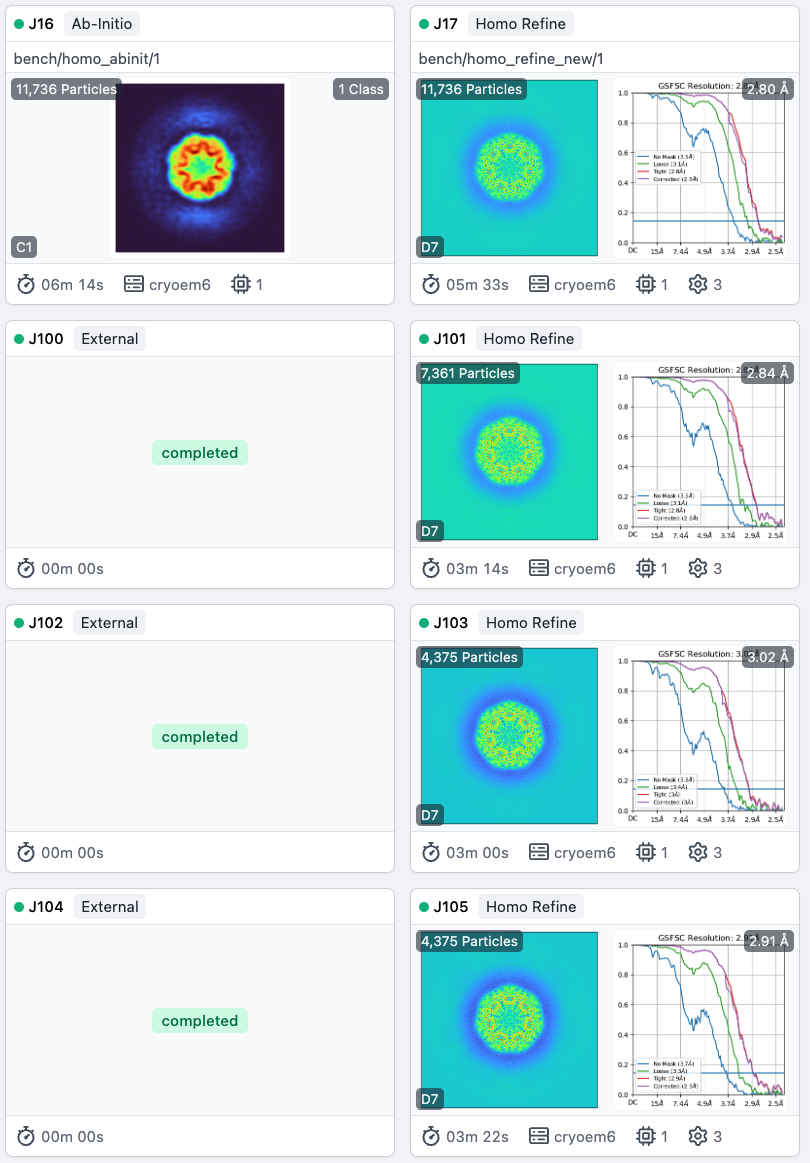

Things to try: 
- check if the code indeed rejected particles with larger shifts
- use shift w.r.t. mean refined defocus either within exposure or across all exposures
- use a scaled version of the shift as a rejection criterion
- reject particles with high defocus shift from a "dirtier" particle set, for example after omitting 2D classification-based "clean-up"
- ...